<a href="https://colab.research.google.com/github/Lakshmi-krishna-vr/Computational_Optimization_/blob/main/Micro_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Required Libraries

In [ ]:
!pip install pulp

## Import Libraries

In [ ]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os

## Load and Filter Data from CSV Files

In [ ]:
# Cell 3: Load Data
print("Loading data from CSV files...")

# Read the uploaded CSV files
demands_df = pd.read_csv('demands.csv')
facilities_df = pd.read_csv('facilities.csv')
warehouses_df = pd.read_csv('warehouses.csv')
costs_df = pd.read_csv('transportation_costs.csv')

# Critical facilities and warehouses for the Micro-Project
target_facilities = ['MED_CENTER', 'ENG_BUILDING', 'SCIENCE_HALL', 'DORM_A', 'DORM_B', 'LIBRARY']
target_warehouses = ['WH_NORTH', 'WH_SOUTH', 'WH_EAST']

# Filter DataFrames to only include the required locations
demands_df = demands_df[demands_df['facility_id'].isin(target_facilities)]
facilities_df = facilities_df[facilities_df['facility_id'].isin(target_facilities)]
warehouses_df = warehouses_df[warehouses_df['warehouse_id'].isin(target_warehouses)]

# Create clean lists of IDs
facilities = demands_df['facility_id'].tolist()
warehouses = warehouses_df['warehouse_id'].tolist()

# Extract Coordinates for Map Generation (Longitude = X, Latitude = Y)
locations = {}
for _, row in facilities_df.iterrows():
    locations[row['facility_id']] = (row['longitude'], row['latitude'])
for _, row in warehouses_df.iterrows():
    locations[row['warehouse_id']] = (row['longitude'], row['latitude'])

print("Data loaded and filtered successfully!")

Loading data from CSV files...
Data loaded and filtered successfully!


## Data Annualization

In [ ]:
# Cell 4: Data Pre-processing (Annualizing)

# Annual Demand (Daily * 365)
annual_demand = {
    row['facility_id']: row['daily_demand'] * 365
    for _, row in demands_df.iterrows()
}

# Annual Capacity (Daily * 365)
annual_capacity = {
    row['warehouse_id']: row['capacity'] * 365
    for _, row in warehouses_df.iterrows()
}

# Annual Fixed Costs = (Construction Cost / 10 years) + (Daily Operational Cost * 365)
fixed_costs = {
    row['warehouse_id']: (row['construction_cost'] / 10) + (row['operational_cost'] * 365)
    for _, row in warehouses_df.iterrows()
}

# Transportation Costs Matrix
transport_costs = {}
for _, row in costs_df.iterrows():
    w = row['from_warehouse']
    f = row['to_facility']
    if w in target_warehouses and f in target_facilities:
        transport_costs[(w, f)] = row['cost_per_unit']

print("Data annualized and cost matrix created.")

Data annualized and cost matrix created.


## Initialize Model & Variables

In [ ]:
# Cell 5: Initialize Model
prob = pulp.LpProblem("Campus_City_Emergency_Distribution", pulp.LpMinimize)

# Decision Variables
# 1. Binary: Open Warehouse? (0 or 1)
warehouse_vars = pulp.LpVariable.dicts("Open", warehouses, cat='Binary')

# 2. Continuous: Shipment Quantity (must be >= 0)
flow_vars = pulp.LpVariable.dicts("Ship", (warehouses, facilities), lowBound=0, cat='Continuous')

print("Model and decision variables initialized.")

Model and decision variables initialized.


## Define Objective Function & Constraints

In [ ]:
# Cell 6: Objective & Constraints

# --- OBJECTIVE FUNCTION ---
# Minimize (Fixed Costs + Transport Costs)
prob += (
    pulp.lpSum([fixed_costs[w] * warehouse_vars[w] for w in warehouses]) +
    pulp.lpSum([transport_costs[(w, f)] * flow_vars[w][f] for w in warehouses for f in facilities])
), "Total_Annual_Cost"

# --- CONSTRAINTS ---
# Constraint 1: Demand Satisfaction (Exact match)
for f in facilities:
    prob += pulp.lpSum([flow_vars[w][f] for w in warehouses]) == annual_demand[f], f"Demand_{f}"

# Constraint 2: Capacity Limit & Linkage (Shipments <= Capacity * Is_Open)
for w in warehouses:
    prob += pulp.lpSum([flow_vars[w][f] for f in facilities]) <= annual_capacity[w] * warehouse_vars[w], f"Capacity_{w}"

# Constraint 3: Select exactly 2 warehouses
prob += pulp.lpSum([warehouse_vars[w] for w in warehouses]) == 2, "Select_Exactly_Two"

# Constraint 4: Budget limit <= $1,500,000
total_cost_expr = (
    pulp.lpSum([fixed_costs[w] * warehouse_vars[w] for w in warehouses]) +
    pulp.lpSum([transport_costs[(w, f)] * flow_vars[w][f] for w in warehouses for f in facilities])
)
prob += total_cost_expr <= 1500000, "Budget_Limit"

print("Objective function and constraints added to the model.")

Objective function and constraints added to the model.


## Solve & Generate Text Report

In [ ]:
# Cell 7: Solve the Model
prob.solve()
status = pulp.LpStatus[prob.status]

# Generate Report
if status == 'Optimal':
    total_cost = pulp.value(prob.objective)

    print("="*60)
    print("  OPTIMIZATION RESULTS REPORT")
    print("="*60)
    print(f"Solution Status:   {status}")
    print(f"Total Annual Cost: ${total_cost:,.2f}")
    print(f"Budget Limit:      $1,500,000.00")
    print(f"Savings vs Budget: ${1500000 - total_cost:,.2f}")
    print("-" * 60)

    open_warehouses = []
    active_routes = []

    print("\n WAREHOUSE DECISIONS:")
    for w in warehouses:
        is_open = "OPEN" if warehouse_vars[w].varValue == 1 else "CLOSED"
        if is_open == "OPEN":
            open_warehouses.append(w)
            used_capacity = sum(flow_vars[w][f].varValue for f in facilities)
            utilization = (used_capacity / annual_capacity[w]) * 100
            print(f"   {w} is {is_open}")
            print(f"     - Annual Fixed Cost: ${fixed_costs[w]:,.2f}")
            print(f"     - Capacity Utilized: {used_capacity:,.0f} / {annual_capacity[w]:,.0f} units ({utilization:.1f}%)")

    print("\n OPTIMAL DISTRIBUTION PLAN (Annual Units & Cost):")
    print(f"  {'FROM WAREHOUSE':<18} {'TO FACILITY':<15} {'QTY SHIPPED':<12} {'TRANSPORT COST'}")
    print("  " + "-"*65)
    for w in warehouses:
        if warehouse_vars[w].varValue == 1:
            for f in facilities:
                qty = flow_vars[w][f].varValue
                if qty > 0:
                    route_cost = qty * transport_costs[(w, f)]
                    active_routes.append((w, f, qty))
                    print(f"  {w:<18} {f:<15} {qty:<12.0f} ${route_cost:,.2f}")

    print("="*60)
else:
    print(f"Optimization failed! Status: {status}")

  OPTIMIZATION RESULTS REPORT
Solution Status:   Optimal
Total Annual Cost: $959,466.05
Budget Limit:      $1,500,000.00
Savings vs Budget: $540,533.95
------------------------------------------------------------

 WAREHOUSE DECISIONS:
   WH_NORTH is OPEN
     - Annual Fixed Cost: $322,000.00
     - Capacity Utilized: 69,350 / 146,000 units (47.5%)
   WH_SOUTH is OPEN
     - Annual Fixed Cost: $283,500.00
     - Capacity Utilized: 28,835 / 127,750 units (22.6%)

 OPTIMAL DISTRIBUTION PLAN (Annual Units & Cost):
  FROM WAREHOUSE     TO FACILITY     QTY SHIPPED  TRANSPORT COST
  -----------------------------------------------------------------
  WH_NORTH           MED_CENTER      29565        $113,233.95
  WH_NORTH           ENG_BUILDING    10950        $38,653.50
  WH_NORTH           DORM_A          17885        $61,882.10
  WH_NORTH           LIBRARY         10950        $40,186.50
  WH_SOUTH           SCIENCE_HALL    10220        $35,974.40
  WH_SOUTH           DORM_B          18615  

## Generate Visual Network Map

🗺️ Generating Network Map...


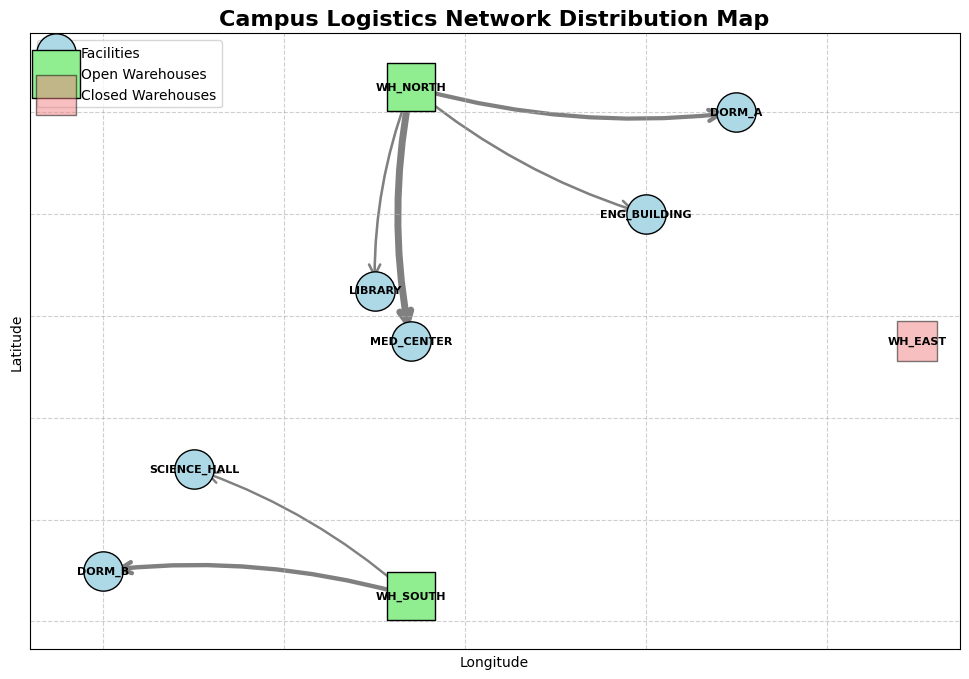

In [ ]:
# Cell 8: Network Map Visualization
if status == 'Optimal':
    print("🗺️ Generating Network Map...")

    plt.figure(figsize=(12, 8))
    G = nx.DiGraph() # Directed graph for shipments

    # Add Nodes
    for f in facilities:
        G.add_node(f, type='facility', pos=locations[f])
    for w in warehouses:
        w_status = 'open' if warehouse_vars[w].varValue == 1 else 'closed'
        G.add_node(w, type=f'warehouse_{w_status}', pos=locations[w])

    # Add Edges (Only for active routes)
    for w, f, qty in active_routes:
        G.add_edge(w, f, weight=qty)

    pos = nx.get_node_attributes(G, 'pos')

    # Draw Facilities (Blue Circles)
    nx.draw_networkx_nodes(G, pos, nodelist=facilities, node_color='lightblue',
                           node_size=800, edgecolors='black', label="Facilities")

    # Draw Open Warehouses (Green Squares)
    nx.draw_networkx_nodes(G, pos, nodelist=open_warehouses, node_color='lightgreen',
                           node_size=1200, node_shape='s', edgecolors='black', label="Open Warehouses")

    # Draw Closed Warehouses (Red Faded Squares)
    closed_warehouses = [w for w in warehouses if w not in open_warehouses]
    nx.draw_networkx_nodes(G, pos, nodelist=closed_warehouses, node_color='lightcoral',
                           node_size=800, node_shape='s', edgecolors='black', alpha=0.5, label="Closed Warehouses")

    # Draw Edges (Shipment routes) - Thickness based on quantity shipped
    max_qty = max([qty for _, _, qty in active_routes]) if active_routes else 1
    edge_widths = [(G[u][v]['weight'] / max_qty) * 5 for u, v in G.edges()]

    nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_widths,
                           arrowsize=20, arrowstyle='->', connectionstyle="arc3,rad=0.1")

    # Add Labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

    # Formatting the plot
    plt.title("Campus Logistics Network Distribution Map", fontsize=16, fontweight='bold')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(scatterpoints=1, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show() # In Colab, plt.show() renders the map directly under the cell
else:
    print("Cannot generate map because optimal solution was not found.")